In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import os

In [2]:
df = pd.read_csv(os.path.join('..','data','brfss.csv'))
df = df.dropna(subset=['htm3','wtkg2'])

In [3]:
df.head()

,Unnamed: 0,age,sex,wtyrago,finalwt,wtkg2,htm3
0,0,82.0,2,76.363636,185.870345,70.91,157.0
1,1,65.0,2,72.727273,126.603027,72.73,163.0
3,3,61.0,1,73.636364,517.926275,73.64,170.0
4,4,26.0,1,88.636364,1252.624630,88.64,185.0
5,5,42.0,1,118.181818,415.161314,109.09,183.0


In [4]:
def pearson_coeff(x,y):
    x = np.asarray(x)
    y = np.asarray(y)
    
    xmean = np.mean(x)
    ymean = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    xi = [(val-xmean)/std_x for val in x] 
    yi = [(val-ymean)/std_y for val in y]
    
    return sum(xi*np.transpose(yi))/len(x)

def leastSquares(xs,ys):
    r = pearson_coeff(xs,ys)
    slope = r*(np.std(ys)/np.std(xs))
    intercept = np.mean(ys)-slope*np.mean(xs)
    return slope,intercept

def fitLine(xs,slope,intercept):
    fit_xs = np.sort(xs)
    fit_ys = fit_xs*slope+intercept
    return fit_xs,fit_ys

Text(0.5,0,'Height')

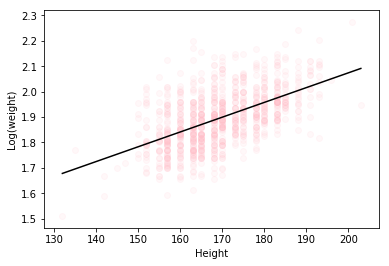

In [5]:
hgt = df['htm3']
log_wgt = np.log10(df['wtkg2'])

slope,intercept = leastSquares(hgt,log_wgt)

fit_xs,fit_ys = fitLine(hgt,slope,intercept)
plt.plot(fit_xs,fit_ys,color='black')
plt.scatter(hgt,log_wgt,alpha=0.1,color='pink')
plt.ylabel('Log(weight)')
plt.xlabel('Height')

In [6]:
slope,intercept

(0.0058218195870721355, 0.9092247336676834)

In [7]:
def residuals(xs,ys,slope,intercept):
    return ys-(xs*slope+intercept)

def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

def percentile(p,series):
    x,y = compute_cdf(series)
    percentiles = dict(zip(y,x))
    seq = [percentiles.get(x) for x in percentiles.keys() if x<=p]
    if len(seq) == 0:
        return None
    else:
        return max(seq)

Text(0,0.5,'residual')

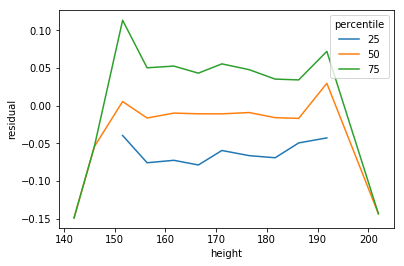

In [8]:
df['residual'] = pd.Series(residuals(hgt,log_wgt,slope,intercept))

bins = np.arange(130,210,step=5)
indices = np.digitize(hgt,bins)
groups = df.groupby(indices)

for p in [0.25,0.50,0.75]:
    xs = []
    ys = [] 
    for i,group in groups:
        res = group['residual'].values
        height = group['htm3']
        percent = percentile(p,res)
        if percent!=None:
            xs.append(np.mean(height))
            ys.append(percent)

    plt.plot(xs,ys,label=int(p*100))
    plt.legend(title='percentile')
plt.xlabel('height')
plt.ylabel('residual')

In [9]:
# pearson coefficient
pearson_coeff(hgt,log_wgt)

0.5450578123262366

In [10]:
# calculate the R-Squared of this linear fit
r2 = np.square(pearson_coeff(hgt,log_wgt))

def r_squared(ys,res):
    return 1-np.var(res)/np.var(ys)

coeff = r_squared(log_wgt,df['residual'])
coeff,r2

(0.29708801877786306, 0.297088018777863)

The knowing log(wgt) we can explain 30% of the variance of height

If you were trying to guess someone’s weight, 30% of the time
it helps to know their height

In [11]:
# slope test

class SlopeTest:
    def __init__(self,xs,ys):
        self.xs= xs
        self.ys=ys
    
    def testStatistic(self,data1,data2):
        slope, intercept = leastSquares(data1,data2)
        return slope
    
    def makeModel(self):
        y_mean = np.mean(self.ys)
        self.res = np.mean(self.ys)-self.ys
        return y_mean+np.random.permutation(self.res)
    
    def p_value(self):
        self.slopes = []
        iters = 1000
        for _ in range(iters):
            null_hypo = self.makeModel()
            slope = self.testStatistic(self.xs,null_hypo)
            self.slopes.append(slope)
        return len([x for x in self.slopes if x > self.testStatistic(self.xs,self.ys)])/iters
    

s1 = SlopeTest(hgt,log_wgt)
s1.p_value()

0.0

The slope test proves our hypothesis is wrong indicating there is a relation between the two variables

In [12]:
def calc_pmf(series):
    pmf = series/sum(series)
    return series.index,pmf

Text(0,0.5,'Probability')

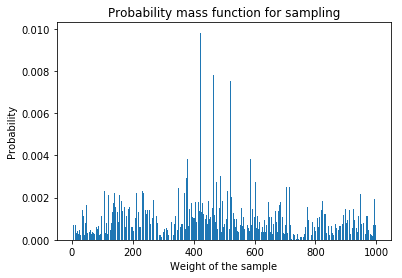

In [13]:
index,prob = calc_pmf(df['finalwt'])
plt.bar(index,prob)
plt.title('Probability mass function for sampling')
plt.xlabel('Weight of the sample')
plt.ylabel('Probability')

In [14]:
est_wgt = [np.random.choice(df['htm3'],replace=True,p=prob,size=df['htm3'].shape) for _ in range(100)]
est = [np.random.choice(df['htm3'],replace=True,size=df['htm3'].shape) for _ in range(100)]
est_mean_wgt = [np.mean(x) for x in est_wgt]
est_mean = [np.mean(x) for x in  est]

In [15]:
def compute_CI(values,CI):
    U_CI = CI+(1-CI)/2
    L_CI = (1-CI)/2
    
    x1,y1 = compute_cdf(values)
    low = percentile(L_CI,x1)
    high = percentile(U_CI,x1)
    return low,high

title = ['Weighted','Unweighted']
means =[np.mean(est_mean_wgt),np.mean(est_mean)]
std_errors = [np.std(est_mean_wgt),np.std(est_mean)]
CIs = [compute_CI(est_mean_wgt,0.9),compute_CI(est_mean,0.9)]
results= [means,std_errors,CIs]
pd.DataFrame(results,columns=title,index=['Mean','Std Error','90% CI'])

,Weighted,Unweighted
Mean,171.385,169.127
Std Error,0.382101,0.321515
90% CI,"(170.73396424815982, 171.96740273396424)","(168.6603575184017, 169.62565720294427)"


The estimated mean height is almost 2 cm taller 
if we take into account the sampling weights and this difference is much bigger than the sampling error.


In [17]:
np.std(hgt), np.std(df['residual'])

(10.232543807915086, 0.0916326528070208)